# Welcome to this tutorial! 🎉

<span style="font-size:18px;"> Are you interested in optimizing your machine learning models? Want to learn how to make them smaller and faster? You’re in the right place! In this tutorial, we will guide you through the general process and flow of **applying quantization** to a machine learning model. We will use **QKeras** to build our model and then show you how to convert it into a bitstream using **HLS4ML**. By the end of this tutorial, you will have a solid understanding of model quantization and be well on your way to optimizing your own models. </span>

# Step 1 Set up your enviroment

<span style="font-size:18px;"> In this step, we will install all the necessary packages. Please note that we will be using **special versions of hls4ml and qkeras** that have been modified to support additional features. We highly recommended to create an empty enviroment for the following steps.</span>

## Important Note:
<span style="font-size:18px;"> We have made modifications to the official qkeras and hls4ml packages to enable support for new layers that are not available in the official versions. Some of these new layers include MultiHeadAttention, Quantized_Softmax, LayerNormalization, and others. This is why we are installing these packages from specific repositories (not the official ones).</span>

### Qkeras: Install Qkeras from UW ACME repository. You can find it [Here](https://github.com/uw-acme/qkeras).
<span style="font-size:18px;"> pip install git+https://github.com/uw-acme/qkeras.git </span>

### HLS4ML: Install HLS4ML from UW ACME repository. You can find it [Here](https://github.com/Ethan0Jiang/hls4ml).
<span style="font-size:18px;"> pip install git+https://github.com/Ethan0Jiang/hls4ml.git </span>

### TensorFlow: We recommend using TensorFlow version 2.9.1 for the best compatibility. Please ensure that your TensorFlow version is 2.9.1 or higher.
<span style="font-size:18px;"> pip install tensorflow==2.9.1 </span>

### Matplotlib:
<span style="font-size:18px;"> pip install matplotlib </span>

<span style="font-size:18px;"> **After installing the required packages, import them now as we will be using them throughout the rest of this tutorial.**</span>

In [2]:
###############################
## Import Necessary Packages ##
###############################
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

from qkeras import *
from qkeras.qlayers import QMultiHeadAttention
from qkeras.qlayers import QEinsumDense
from qkeras.qlayers import QDense
from qkeras.qnormalization import QLayerNormalization
from qkeras.qlayers import QActivation
from qkeras.utils import model_quantize


import hls4ml
import os

/home/dennis/transformer/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


<span style="font-size:18px;"> Let's also prepare the dataset for later use. For those interested in more information about the dataset, please refer to the 'GW_transformer.mp4' video. You can find this video in the 'GW3_Glitch' folder, which is located in the same directory level as this repository. </span>

In [2]:
anomaly_class = {
    'bkg': 0,
    'glitches_new': 1
}

def readfile(anomaly_type):
  # only look at L1 for now
  data = np.load(anomaly_type+'.npy')[:,0,:]
  ids = np.full(data.shape[0], anomaly_class[anomaly_type], dtype=int)  
  return data, ids


x = np.array([])
y = np.array([])
for anom in anomaly_class.keys():
  x_anom, y_anom = readfile(anom)
  x = np.concatenate((x, x_anom), axis=0) if x.size else x_anom
  y = np.concatenate((y, y_anom), axis=0) if y.size else y_anom

# choose the split
split = 0.2



def split_train_test(x, y, split):
  split = int(x.shape[0]*(1-split))
  x_train, y_train = x[:split,:], y[:split]
  x_test, y_test = x[split:,:], y[split:]
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
  x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
  return x_train, y_train, x_test, y_test

np.random.seed(3)
idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]


x_train, y_train, x_test, y_test = split_train_test(x, y, split)

n_classes = len(anomaly_class.values())

# mix events
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')
print(f'Number of classes: {n_classes}')

x train/test shapes: (15930, 100, 1) (3983, 100, 1)
y train/test shapes: (15930,) (3983,)
Number of classes: 2


# Step 2: Build a Keras Model

<span style="font-size:18px;">In this step of the tutorial, we will walk through building a moderately complex model.

In [32]:
#############################################
## Definition of Transformer Encoder Block ##
#############################################
''' 
    This function defines a single transformer encoder block, 
    which is a fundamental component of the transformer model. 
    The encoder block consists of two main parts: a multi-head 
    attention mechanism followed by a feed-forward neural network. 
    Layer normalization and residual connections are also employed.
'''

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-Head Attention and Residual Connection
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])
    res = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Part with Residual Connection
    x = layers.Dense(ff_dim, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    x = layers.Add()([x, res])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x


#################################
## Building the Complete Model ##
#################################
'''
    This function defines the entire model architecture. 
    It takes various parameters including the shape of the input, 
    the size and number of heads in the multi-head attention mechanism, 
    dimensions for the feed-forward networks, and more. 
    The function constructs the model by stacking the specified 
    number of transformer encoder blocks followed by a set of 
    fully connected layers (MLP) for final classification.
'''

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.2,
    mlp_dropout=0.2,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # Initial Dense and Normalization Layer
    x = layers.Dense(ff_dim)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Stacking Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Final Classification Head
    x = layers.Dense(1, activation="relu")(x)
    x = layers.Flatten()(x)
    
    # Multi-Layer Perceptron (MLP) for Classification
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)


# Setting the Input Shape
input_shape = x_train.shape[1:]

# Building the Model
# Creating an instance of the model with the specified hyperparameters.
model = build_model(
    input_shape,
    head_size=16,
    num_heads=2,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[20, 8],
    mlp_dropout=0.2,
    dropout=0.25,
)

# Compiling the Model
# Setting up the loss function, optimizer, and evaluation metrics for training.
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

# Displaying the Model's Architecture
# This prints a summary of the model's layers, output shapes, and number of parameters.
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 100, 4)       8           ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 100, 4)      8           ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 100, 4)      612         ['layer_normalization[0][0]',

<span style="font-size:18px;"> This model is designed based on the transformer architecture and is utilized as a classifier. Its primary function is to classify gravity waves, helping to distinguish genuine gravity wave signals from a significant amount of noise in the data.

<span style="font-size:18px;"> We have chosen this specific model for the tutorial for several reasons:

<span style="font-size:18px;"> **Wide Applicability**: The model covers a majority of the layers that researchers might need in their own projects, making it a great example to learn from.

<span style="font-size:18px;">**Practical Use Case**: The task of detecting gravity waves amidst noisy data is a real-world challenge, and this model provides a practical solution to this problem.
    
<span style="font-size:18px;">**Demonstration of Complexity**: Though the model is more complex than simple examples, it remains accessible for learners. This makes it an excellent choice for demonstrating quantization without overwhelming complexity.

## Optional: You could choose to train the model, or we have a pre-trained version, you can load the model from ./FPModel directory

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)]

history = model.fit(
                    x_train,
                    y_train,
                    validation_split=0.2,
                    epochs=120,
                    batch_size=100,
                    callbacks=callbacks,
                    )
model.evaluate(x_test, y_test)

# Step 3: Introduction to Quantization

<span style="font-size:18px;"> Quantization is a technique used to optimize machine learning models, making them faster and more memory efficient. In essence, it involves converting the weights and, optionally, activations of a model from floating point numbers to lower precision formats, such as int8 or int16. This process significantly reduces the size of the model, making it easier to deploy on resource-constrained devices like microcontrollers (MCUs) and Field Programmable Gate Arrays (FPGAs). </span>

## Why is Quantization Important?
<span style="font-size:18px;"> 1. **Reduced Model Size:** Quantization dramatically shrinks the size of models, which is critical for deployment in environments with limited memory. </span>

<span style="font-size:18px;"> 2. **Increased Speed:** With smaller, simpler numerical formats, computations can be faster, which is key for real-time applications. </span>

<span style="font-size:18px;"> 3. **Lower Power Consumption:** Reduced computation resources mean less power is needed, which is essential for battery-powered devices. </span>

## Quantization Aware Training (QAT):

<span style="font-size:18px;"> QAT simulates the effects of quantization during the training process. This means the model learns to adapt to the lower precision format from the start, often leading to higher accuracy when the quantized model is deployed.</span>

<span style="font-size:18px;"> __Applications:__ It is especially beneficial when deploying models onto edge devices like MCUs or FPGAs, where both size and performance matter.</span>

<span style="font-size:18px;"> __Advantages:__ Since QAT considers quantization effects during training, the resulting model is often more robust and accurate after quantization.</span>

## Post-Training Quantization (PTQ):

<span style="font-size:18px;"> PTQ is applied after a model has been trained. It converts the weights (and potentially activations) of an already-trained model into lower precision formats.</span>

<span style="font-size:18px;"> ***Applications:*** PTQ is a good choice when you have a pre-trained model and you need to deploy it quickly or when you don’t have the resources for retraining. It is often used to improve the speed of models that run on servers or in the cloud, where latency is a critical factor.</span>

<span style="font-size:18px;"> ***Advantages:*** PTQ is generally simpler and faster than QAT because it doesn't require re-training the model. It often works well if the model’s original accuracy is high enough to absorb the small drop usually caused by quantization.</span>

<span style="font-size:18px;">  ***Note:*** PTQ indeed mostly targets the weights of the model, but some techniques can also quantize the activations (the outputs of layers). Whether to use QAT or PTQ also depends on the specific deployment needs. If the model is intended for a highly resource-constrained environment like an MCU or FPGA, QAT is often the recommended approach due to its typically higher post-quantization accuracy.</span>

<span style="font-size:18px;"> ***QKeras*** is an extension of Keras that allows you to easily apply quantization to your machine learning models. Essentially, QKeras allows you to replace the standard Keras layers with quantized versions. The main aim is to enable experimentation with low-bitwidth data types, while keeping the Keras interface. ***To have QKeras quantize your model, you need to specify which quantizer to apply to which part of each layer.***</span>

### What is a Quantizer?
<span style="font-size:18px;"> A quantizer is a function that maps a large set to a smaller set, primarily in digital signal processing. In the context of neural networks, quantizers are used to map the continuous set of weight, bias, or activation values to a smaller, discrete set. This is how QKeras, like many quantization packages, reduces the model size and computation demand.</span>

### Where are Quantizers Applied?
<span style="font-size:18px;"> Kernel (or Weights): The quantizer constrains the weights of the network layer to a reduced set of values, which is the essence of weight quantization.</span>

<span style="font-size:18px;"> Bias: Just like with weights, bias values can also be quantized to lower precision, reducing the model’s memory footprint.</span>

<span style="font-size:18px;"> Activations: The outputs of layers, or activations, can also be quantized. This is vital when deploying on low-precision hardware where both weights and activations need to be in low precision.</span>



<span style="font-size:18px;"> For example, consider a simple dense (fully connected) layer in a neural network. Normally, this layer contains floating-point weights and biases. When we apply quantization, the quantizers are inserted in places where calculations and representations are made, effectively reducing the numerical precision of these parameters. </span>

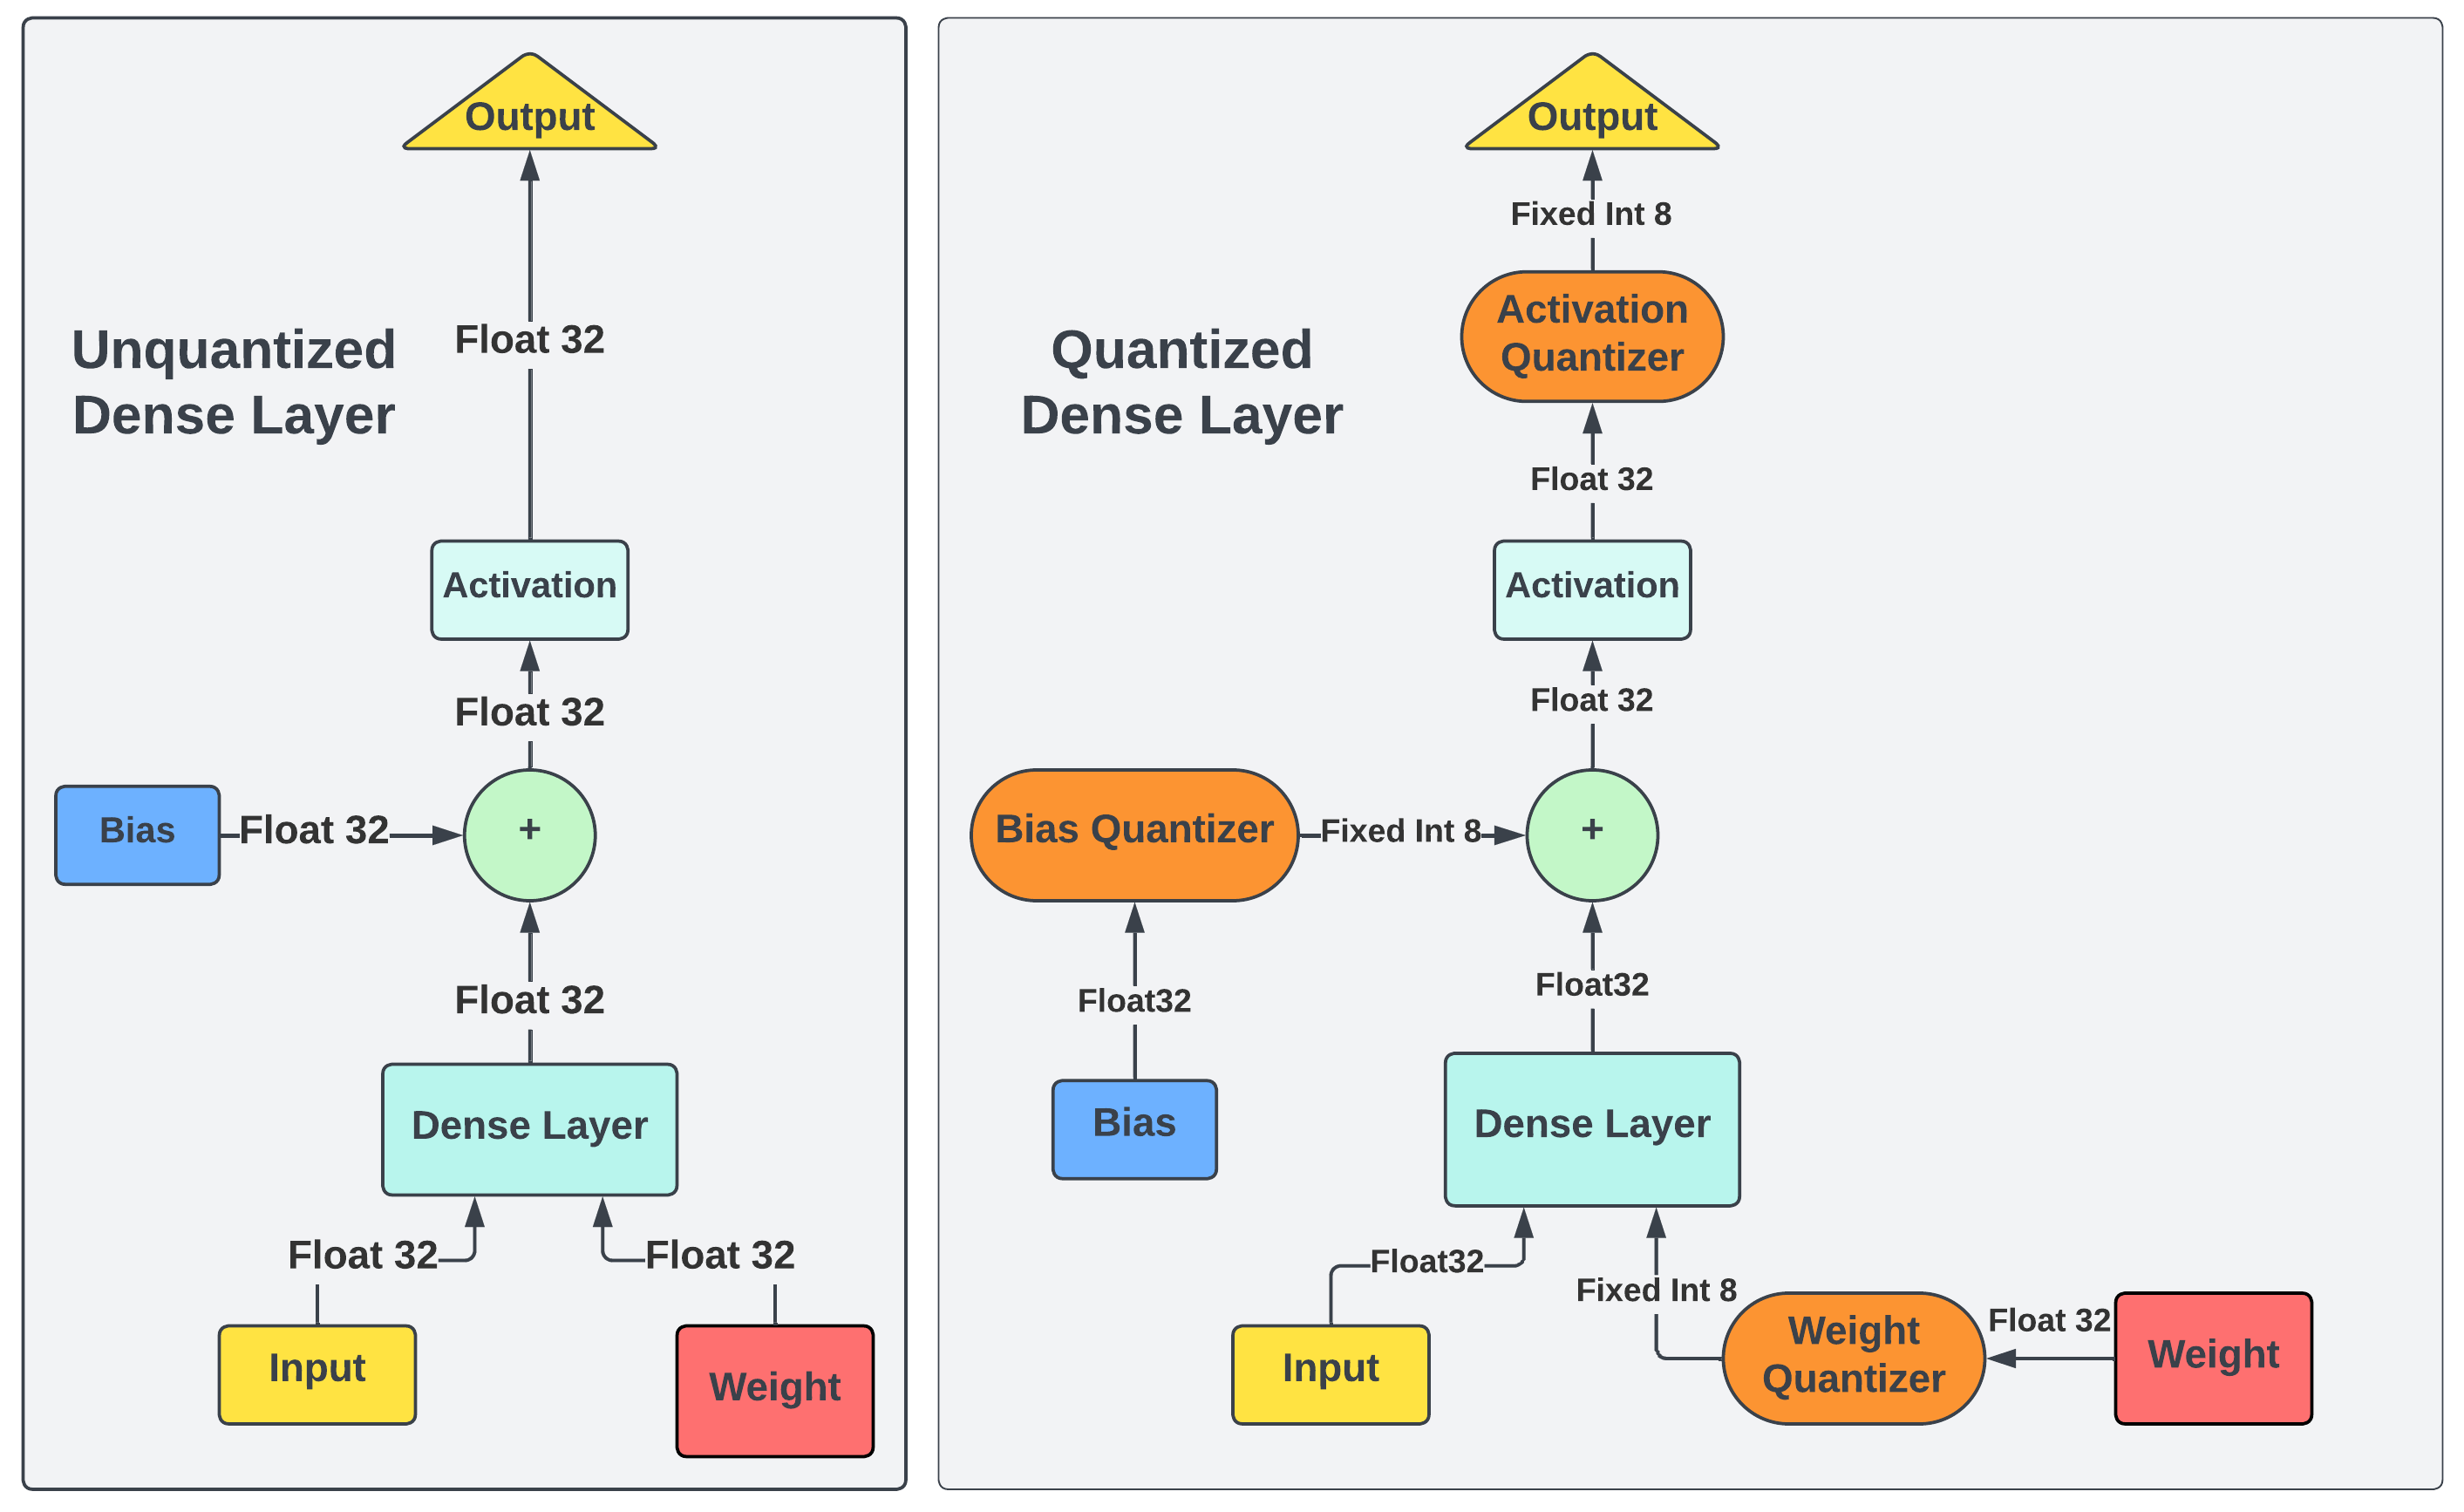

<span style="font-size:18px;"> Among the several types of quantizers available in QKeras, we are focusing on ***quantized_bits***, ***quantized_softmax***, and ***quantized_relu*** as our main quantizer. Here is the explanation and usage of the quantized_bits quantizer in QKeras:</span>

In [ ]:
quantized_bits(bits=8, integer=0, symmetric=0, keep_negative=1, alpha=None, use_stochastic_rouding=False)

<span style="font-size:18px;"> ***bits:*** This is the total number of bits that will be used to represent the weights, biases, or activations. For example, if bits=8, then we are using 8-bit quantization.</span>

<span style="font-size:18px;">***integer:*** This specifies the number of bits used for representing the integer part of the numbers. The remaining bits (bits - integer) will be used for the fractional part.</span>

<span style="font-size:18px;">***symmetric:*** If set to 1, the quantization will be symmetric. This means that the range of values will be evenly distributed around zero. For example, for 3-bit symmetric quantization, the range of values will be from -3 to +3.</span>

<span style="font-size:18px;">***keep_negative:*** If set to 1, the negative part of the range is kept, otherwise it is clipped. This is useful for activations like ReLU which do not have negative values.</span>

<span style="font-size:18px;">***alpha:*** This is a scale factor that is learned during the quantization-aware training process. If set to None, the scale factor is learned. Otherwise, you can set it to a specific value.</span>

<span style="font-size:18px;">***use_stochastic_rouding:*** If set to True, stochastic rounding is used instead of deterministic rounding when quantizing the numbers. This can sometimes improve the accuracy of the quantized model by adding some noise to the rounding process.</span>



<span style="font-size:18px;"> Here is the explanation and usage of the quantized_relu quantizer in QKeras:</span>

In [ ]:
quantized_relu(bits=8, integer=0, use_sigmoid=0, use_stochastic_rounding=False)

<span style="font-size:18px;">***bits:*** This is the total number of bits that will be used to represent the output of this activation function. For example, if bits=8, then the output is quantized to 8 bits.</span>

<span style="font-size:18px;">***integer:*** This specifies the number of bits used for representing the integer part of the numbers. The remaining bits (bits - integer) will be used for the fractional part. This is used to configure the range of values that this function can output.</span>

<span style="font-size:18px;">***use_sigmoid:*** If set to 1, this parameter will make the function behave like a quantized version of the sigmoid activation function instead of ReLU. In this mode, the function will squash its input into the range [0, 1] and then quantize it. If set to 0, the function behaves like a quantized ReLU.</span>

<span style="font-size:18px;">***use_stochastic_rounding:*** If set to True, stochastic rounding is used instead of deterministic rounding when quantizing the numbers. Stochastic rounding can sometimes lead to more accurate representations by introducing randomness into the rounding process, which might prevent consistent biases in quantization.</span>

<span style="font-size:18px;"> Here is the explanation and usage of the quantized_softmax quantizer in QKeras:</span>

In [ ]:
quantized_softmax(bits=8, use_stochastic_rounding=False)

<span style="font-size:18px;">***bits:*** This is the total number of bits that will be used to represent the output of this activation function. For example, if bits=8, then the output (the probabilities) is quantized to 8 bits.</span>

<span style="font-size:18px;">***use_stochastic_rounding:*** If set to True, stochastic rounding is used instead of deterministic rounding when quantizing the numbers. Stochastic rounding can sometimes lead to more accurate representations by introducing randomness into the rounding process, which might prevent consistent biases in quantization.</span>

<span style="font-size:18px;">For those who are interested in other types of quantizers, such as ternary, binary, and more, please visit [the QKeras Official Site](https://github.com/google/qkeras/blob/master/notebook/QKerasTutorial.ipynb) for further details and in-depth documentation.</span>

## Getting Started with Quantization in QKeras
<span style="font-size:18px;"> We will start with ***Post-Training Quantization (PTQ)***, as it is simpler to achieve in QKeras. This involves taking a trained model and then quantizing it, as opposed to Quantization Aware Training (QAT), where the model is aware of the quantization during the training process itself. </span>

<span style="font-size:18px;"> Here we load a pre-trained model with the same structure as what we built in the previous chapter: </span>

In [33]:
model = load_model('./FPModel')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 100, 4)       8           ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 100, 4)      8           ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 100, 4)      612         ['layer_normalization[0][0]',

<span style="font-size:18px;"> In QKeras, PTQ can be done by directly using the ***model_quantize*** function. </span>
    
<span style="font-size:18px;"> ***model_quantize(model, quantizer_config, activation_bits, custom_objects=None, transfer_weights=False)*** </span>

<span style="font-size:18px;">***model:*** A Keras model instance </span>

<span style="font-size:18px;">***quantizer_config:*** This ***dictionary*** maps the names of the layers in the model to the quantizers you want to apply to those layers. For each layer, you can specify the quantizers for the weights, biases, and activations. </span>

<span style="font-size:18px;">***activation_bits:*** This specifies the number of bits to use when quantizing the activation functions in the model, this is only specified for unamed activation functions, with this parameter probably being removed in future versions. </span>

<span style="font-size:18px;">***custom_objects:*** If your model includes any custom layers or other custom objects, you should provide them here as a ***dictionary***. The keys should be the names of the custom objects, and the values should be the objects themselves. </span>

<span style="font-size:18px;">***transfer_weights:*** If set to ***True***, this parameter will transfer the weights from the original (pre-trained) model to the new quantized model. If set to ***False***, the new quantized model will be initialized with random weights. </span>

<span style="font-size:18px;"> To specify the quantization scheme for various parts of the model, we need to create a config dictionary. Here is an example of the usage: </span>

In [51]:
# Designate your quantization bit width for both fractional and integer bits.
fractional = 4
integer = 4
total_bits = fractional + integer

config = {
    # To apply the same quantization configuration to all layers of a specific type, 
    # specify the layer type and designate the desired kernel and bias quantizers.
    # If left the kernel and bias quantizer blank, like QLayerNormalization,
    # model quantize will use the default quantizer. 
    # QMultiHeadAttention and QDense configuration are the examples. 
    "QMultiHeadAttention": {
        "kernel_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)",
        "bias_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)"
    },
    "QDense": {
        "kernel_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)",
        "bias_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)"
    },
    # For Normalization layer like BatchNormalization and LayerNormalizaiton,
    # We recommended to use the default quantizer, thus left it blank.
    "QLayerNormalization": {},
    
    # For activation layers separated from the layer, like **Dense --> ReLU** instead of **Dense(activation=ReLU)**
    # You can use this way to make all activation layer use one specific quantizer.
    
    # "QActivation": {f"quantized_relu({total_bits}, {integer})"}
    
    # If you want to make different activation use different quantizer, 
    # you have to specify their activation layer's name
    
    # "Activation layer name" (Which we don't have such structure in this example model)    
    #   ||                       
    # "act_2": "quantized_relu(3)" (More details can be found at https://github.com/google/qkeras/blob/master/notebook/QKerasTutorial.ipynb)
    
    # If you directly applied the activation function right at the end of the layer, like **Dense(activation=ReLU)**
    # You need to use this way
    "dense_1":{
        "activation": f"quantized_relu({total_bits}, {integer})",
        "kernel_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)",
        "bias_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)"
    },
    "dense_3":{
        "activation": f"quantized_relu({total_bits}, {integer})",
        "kernel_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)",
        "bias_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)"
    },
    "dense_5":{
        "activation": f"quantized_relu({total_bits}, {integer})",
        "kernel_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)",
        "bias_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)"
    },
    "dense_6":{
        "activation": f"quantized_relu({total_bits}, {integer})",
        "kernel_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)",
        "bias_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)"
    },
    "dense_7":{
        "activation": f"quantized_relu({total_bits}, {integer})",
        "kernel_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)",
        "bias_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)"
    },
    "dense_8":{
        "activation": f"quantized_softmax({total_bits})",
        "kernel_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)",
        "bias_quantizer": f"quantized_bits({total_bits}, {integer}, 1, alpha=1)"
    },
    
    # Since specify the layer config by their name, it would overwrite the overall group config, 
    # you have to also specify their kernal and bias quantizer again to make them properly quantized.
}

<span style="font-size:18px;"> Now you can use the model_quantized function: </span>

In [52]:
# Have to the transfer_weights to True if PTQ needs to be applied.
qmodel = model_quantize(model, config, total_bits, transfer_weights=True)

# Same as we declair the original model
qmodel.compile(loss="sparse_categorical_crossentropy",
               optimizer=keras.optimizers.Adam(learning_rate=1e-4),
               metrics=["sparse_categorical_accuracy"],)

qmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 dense (QDense)                 (None, 100, 4)       8           ['input_1[0][0]']                
                                                                                                  
 layer_normalization (QLayerNor  (None, 100, 4)      8           ['dense[0][0]']                  
 malization)                                                                                      
                                                                                                  
 multi_head_attention (QMultiHe  (None, 100, 4)      612         ['layer_normalization[0][0]',

<span style="font-size:18px;"> To check if your model is properly quantized, you can either chekc the config for your qmodel or print the weight of the qmodel and compare it with the original model. </span>

In [46]:
# Config Check
for layer in qmodel.layers:
    config = layer.get_config()
    print(config)

# Check if each layer's quantizer been properly changed into the quantizer you desired.

{'batch_input_shape': (None, 100, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}
{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 4, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'QInitializer', 'config': {'initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}, '__passive_serialization__': True}, 'use_scale': True, 'quantizer': {'class_name': 'quantized_bits', 'config': {'bits': 6, 'integer': 4, 'symmetric': 1, 'alpha': 1, 'keep_negative': True, 'use_stochastic_rounding': False, 'qnoise_factor': 1.0}, '__passive_serialization__': True}}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': {'class_name': 'Clip', 'config': {'min_value': -16.0, 'max_value': array(16., dtype=float32)}}, 'bias_constraint': {'class_name': 'Clip', 'config': {'min_value': -16.0, 'max_value': array(16., d

In [47]:
# Weight Check
original_weights = model.get_weights()

print(original_weights)


[array([[-0.67354363, -0.3685642 , -0.15107399, -0.93685913]],
      dtype=float32), array([-0.07215523,  0.02497942, -0.02694131,  0.12369385], dtype=float32), array([1.0911869 , 1.0251955 , 0.9866303 , 0.89997864], dtype=float32), array([ 0.04919659, -0.05790258,  0.0651219 ,  0.01827052], dtype=float32), array([[[ 0.13310145, -0.07405202, -0.13500085, -0.17425454,
          0.10681624, -0.05583369, -0.06450982,  0.13869397,
          0.09306709,  0.19068624, -0.26117316, -0.06593687,
         -0.26411992,  0.04122178,  0.02570088,  0.2782799 ],
        [-0.39908424, -0.4567575 , -0.02911321,  0.40269405,
         -0.50424147,  0.46524024,  0.1594107 ,  0.31136084,
          0.45392993,  0.23342697,  0.14721021,  0.12326197,
         -0.19913678, -0.09750132, -0.47158742,  0.05019401]],

       [[ 0.17184217,  0.02574892, -0.08907895, -0.06089004,
          0.09208405,  0.14915179, -0.16946776,  0.04191624,
         -0.02718686,  0.16373076, -0.10041925, -0.122055  ,
          0.1179

In [48]:
quantized_weights = qmodel.get_weights()

print(quantized_weights)

# Note: if you want to apply the PTQ, you have to set the transfer weight to true
# thus the only way you can chech whether the model has been properly quantized is in the config part

[array([[-0.67354363, -0.3685642 , -0.15107399, -0.93685913]],
      dtype=float32), array([-0.07215523,  0.02497942, -0.02694131,  0.12369385], dtype=float32), array([1.0911869 , 1.0251955 , 0.9866303 , 0.89997864], dtype=float32), array([ 0.04919659, -0.05790258,  0.0651219 ,  0.01827052], dtype=float32), array([[[ 0.13310145, -0.07405202, -0.13500085, -0.17425454,
          0.10681624, -0.05583369, -0.06450982,  0.13869397,
          0.09306709,  0.19068624, -0.26117316, -0.06593687,
         -0.26411992,  0.04122178,  0.02570088,  0.2782799 ],
        [-0.39908424, -0.4567575 , -0.02911321,  0.40269405,
         -0.50424147,  0.46524024,  0.1594107 ,  0.31136084,
          0.45392993,  0.23342697,  0.14721021,  0.12326197,
         -0.19913678, -0.09750132, -0.47158742,  0.05019401]],

       [[ 0.17184217,  0.02574892, -0.08907895, -0.06089004,
          0.09208405,  0.14915179, -0.16946776,  0.04191624,
         -0.02718686,  0.16373076, -0.10041925, -0.122055  ,
          0.1179

In [49]:
model.evaluate(x_test, y_test)

125/125 [==============================] - 1s 7ms/step - loss: 0.0130 - sparse_categorical_accuracy: 0.9972


[0.012995394878089428, 0.997238278388977]

In [53]:
qmodel.evaluate(x_test, y_test)

125/125 [==============================] - 3s 9ms/step - loss: 0.2426 - sparse_categorical_accuracy: 0.9849


[0.24257782101631165, 0.984935998916626]

<span style="font-size:18px;"> In this section, we will delve into ***Quantization Aware Training (QAT)***. </span>

<span style="font-size:18px;"> Just as we specified the quantizer configurations in PTQ, the process for QAT involves replacing standard Keras layers with their quantized counterparts from QKeras during the model construction phase. Instead of quantizing after training, we apply specific quantizers directly to the layers as we build the model. Here's an example: </span>

In [29]:
def transformer_encoder(inputs, head_size, num_heads, total_bits, integer, ff_dim, dropout=0):
    # Quantized Multi-Head Attention Layer
    x = QMultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout, 
                            softmax_bits=total_bits, 
                            kernel_quantizer=quantized_bits(total_bits, integer, 1, alpha=1), 
                            bias_quantizer=quantized_bits(total_bits, integer, 1, alpha=1))(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])
    # Quantize Layer normalization Layer with default setting (Recommended for all normalization layer)
    res= QLayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Part
    # Quantized Dense layer followed by a quantized ReLU activation
    x = QDense(ff_dim, 
               activation=quantized_relu(total_bits, integer), 
               kernel_quantizer=quantized_bits(total_bits, integer, 1, alpha=1), 
               bias_quantizer=quantized_bits(total_bits, integer, 1, alpha=1))(res)
    x = layers.Dropout(dropout)(x)
    # Quantized Dense layer
    x = QDense(inputs.shape[-1], 
               kernel_quantizer=quantized_bits(total_bits, integer, 1, alpha=1), 
               bias_quantizer=quantized_bits(total_bits, integer, 1, alpha=1))(x)
    x = layers.Add()([x, res])
    # Quantize Layer normalization Layer with default setting (Recommended for all normalization layer)
    x = QLayerNormalization(epsilon=1e-6)(x)
    return x

In [30]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    total_bits, 
    integer, 
    dropout=0.2,
    mlp_dropout=0.2,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = QDense(ff_dim, 
               kernel_quantizer=quantized_bits(total_bits, integer, 1, alpha=1), 
               bias_quantizer=quantized_bits(total_bits, integer, 1, alpha=1))(x)
    x = QLayerNormalization(epsilon=1e-6)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, total_bits, integer, ff_dim, dropout)
    
    x = QDense(1, 
               activation=quantized_relu(total_bits, integer), 
               kernel_quantizer=quantized_bits(total_bits, integer, 1, alpha=1), 
               bias_quantizer=quantized_bits(total_bits, integer, 1, alpha=1))(x)
    x = layers.Flatten()(x)
    
    for dim in mlp_units:
        x = QDense(dim, 
                   activation=quantized_relu(total_bits, integer), 
                   kernel_quantizer=quantized_bits(total_bits, integer, 1, alpha=1), 
                   bias_quantizer=quantized_bits(total_bits, integer, 1, alpha=1))(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = QDense(n_classes, 
                     activation=quantized_softmax(bits=total_bits), 
                     kernel_quantizer=quantized_bits(total_bits, integer, 1, alpha=1), 
                     bias_quantizer=quantized_bits(total_bits, integer, 1, alpha=1))(x)
    return keras.Model(inputs, outputs)

<span style="font-size:18px;"> For the majority of layers, the distinction between QKeras layers and standard Keras layers lies in the addition of the kernel_quantizer and bias_quantizer parameters. For more complex layers, such as the QMultiHeadAttention layer, additional parameters like softmax_bits are required. For further details on these layers and their parameters, please refer to the qkeras.layers file or visit the [QKeras official site](https://github.com/google/qkeras/tree/master)." </span>

### Also, you could use model_quantize function to quantize your floating point model and set the transfer_weights to False. It will assign a random weight to your model, and you can then train it usual

<span style="font-size:18px;"> Once the QAT model is constructed, the subsequent steps—from compiling the model, to training it, evaluating its performance, and making predictions—are executed in the same manner as with standard Keras models </span>

In [31]:
# Designate your quantization bit width for both fractional and integer bits.
fractional = 4
integer = 4
total_bits = fractional + integer

# Setting the Input Shape
input_shape = x_train.shape[1:]

# Building the Model
# Creating an instance of the model with the specified hyperparameters.
qmodel = build_model(input_shape,
                    head_size=16,
                    num_heads=2,
                    ff_dim=4,
                    num_transformer_blocks=2,
                    mlp_units=[20,8],
                    mlp_dropout=0.2,
                    dropout=0.25,
                    total_bits= fractional + integer,
                    integer= integer,)

# Compiling the Model
# Setting up the loss function, optimizer, and evaluation metrics for training.
qmodel.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

# Displaying the Model's Architecture
# This prints a summary of the model's layers, output shapes, and number of parameters.
qmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 q_dense_30 (QDense)            (None, 100, 4)       8           ['input_7[0][0]']                
                                                                                                  
 q_layer_normalization_21 (QLay  (None, 100, 4)      8           ['q_dense_30[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 q_multi_head_attention_9 (QMul  (None, 100, 4)      612         ['q_layer_normalization_21[

__________________________________________________________________________________________________


<span style="font-size:18px;"> Now we need to train the model, it could take 5-10 minutes.

In [32]:
callbacks = [keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)]

history = qmodel.fit(
                    x_train,
                    y_train,
                    validation_split=0.2,
                    epochs=120,
                    batch_size=100,
                    callbacks=callbacks,
                    )
qmodel.evaluate(x_test, y_test)

Epoch 1/120
128/128 [==============================] - 10s 39ms/step - loss: 0.3322 - sparse_categorical_accuracy: 0.9164 - val_loss: 0.2307 - val_sparse_categorical_accuracy: 0.9476
Epoch 2/120
128/128 [==============================] - 3s 25ms/step - loss: 0.2827 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.2515 - val_sparse_categorical_accuracy: 0.9476
Epoch 3/120
128/128 [==============================] - 3s 25ms/step - loss: 0.2745 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.2214 - val_sparse_categorical_accuracy: 0.9476
Epoch 4/120
128/128 [==============================] - 3s 25ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.2205 - val_sparse_categorical_accuracy: 0.9476
Epoch 5/120
128/128 [==============================] - 3s 25ms/step - loss: 0.2381 - sparse_categorical_accuracy: 0.9478 - val_loss: 0.2180 - val_sparse_categorical_accuracy: 0.9476
Epoch 6/120
128/128 [==============================] - 3s 25ms/step - loss: 0.2424 - spar

Epoch 46/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.0575 - val_sparse_categorical_accuracy: 0.9915
Epoch 47/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0813 - sparse_categorical_accuracy: 0.9899 - val_loss: 0.0664 - val_sparse_categorical_accuracy: 0.9909
Epoch 48/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.0504 - val_sparse_categorical_accuracy: 0.9915
Epoch 49/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9911 - val_loss: 0.0429 - val_sparse_categorical_accuracy: 0.9934
Epoch 50/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0553 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0449 - val_sparse_categorical_accuracy: 0.9950
Epoch 51/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0465 -

Epoch 91/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0354 - val_sparse_categorical_accuracy: 0.9915
Epoch 92/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.0377 - val_sparse_categorical_accuracy: 0.9947
Epoch 93/120
128/128 [==============================] - 3s 26ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.0368 - val_sparse_categorical_accuracy: 0.9944
Epoch 94/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0314 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0365 - val_sparse_categorical_accuracy: 0.9940
Epoch 95/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.0409 - val_sparse_categorical_accuracy: 0.9931
Epoch 96/120
128/128 [==============================] - 3s 25ms/step - loss: 0.0328 -

[0.027788745239377022, 0.9937233328819275]

# Step 4 HLS Model Conversion by HLS4ML

<span style="font-size:18px;"> After quantization with QKeras, the natural progression is to move towards hardware acceleration. hls4ml is a brilliant tool for this very purpose, bridging the gap between machine learning models and FPGA hardware. </span>

<span style="font-size:18px;"> ***Understanding Layer Implementations in FPGA*** </span>

<span style="font-size:18px;"> FPGA implementations of neural networks often use a combination of digital logic and lookup tables (LUTs) to replicate the functionality of various layers. This is done to achieve both efficient computation and to fit the specific constraints of hardware. </span>

<span style="font-size:18px;"> ***BatchNormalization and LayerNormalization*** </span>

<span style="font-size:18px;"> Normalization layers, whether it's BatchNormalization or LayerNormalization, are designed to standardize the inputs to a specific layer, ensuring that they have a mean output activation close to 0 and a standard deviation close to 1. In FPGAs, the constants (like mean and variance) required for these normalization layers are often pre-computed during training. Because of this, the normalization can be simplified into a set of multiplications and additions.</span>

<span style="font-size:18px;">Given that FPGAs are resource-constrained, using multiplication for each normalization might be expensive in terms of resource utilization. Instead, using a LUT becomes a more viable option. The LUT can quickly map input values to output values without any multiplications, making the operation much faster and efficient on an FPGA. </span>

<span style="font-size:18px;"> ***ReLU and Softmax*** </span>

<span style="font-size:18px;"> The ReLU (Rectified Linear Unit) activation function is straightforward: if the input is positive, it's returned as is; otherwise, it returns zero. This piecewise function can be efficiently implemented using a LUT in FPGAs, making it a preferable choice over digital logic for this operation. </span>

<span style="font-size:18px;">The Softmax function, on the other hand, involves exponentiations and divisions – operations that are resource-intensive on FPGAs. By using a LUT, the FPGA can directly map input values to their softmax probabilities without the need to compute exponentiations, making the process more efficient. </span>

<span style="font-size:18px;"> Besides the layers previously discussed, many other layers utilize LUTs for efficient computation in FPGAs. The accuracy of a LUT is governed by three fundamental parameters: table precision, table range, and table size. </span>

<span style="font-size:18px;"> **Table Precision:** This refers to the number of decimal places or bits the values in the LUT are stored with. Higher precision allows for more exact value representation, but it may also consume more resources.</span>

<span style="font-size:18px;"> **Table Range:** This denotes the range of input values for which the LUT has corresponding output values. A smaller range might not capture all potential input values, leading to inaccuracies. If the range is too narrow, values outside the specified range would be approximated to the closest boundary value in the LUT, which can lead to significant inaccuracies, especially for layers like normalization where precise computation is essential.</span>

<span style="font-size:18px;"> **Table Size:** It represents the number of entries in the LUT. A larger table size can represent the function more accurately across its range. However, it also means that more FPGA resources will be used.</span>

<span style="font-size:18px;"> In general, enhancing these parameters can lead to improved accuracy for most layers. However, it's crucial to strike a balance. Excessively large table sizes or ranges can consume disproportionate FPGA resources without substantial accuracy gains. Especially for normalization layers, an overly large range can lead to sparse LUTs where many input values map to the same output, effectively reducing the LUT's precision and, consequently, the layer's accuracy. </span>

    
### Accumulator precision
<span style="font-size:18px;"> In digital arithmetic operations pivotal to neural networks, like multiplication and convolution, accumulators play a vital role in summing up multiple products or values. A unique aspect of binary arithmetic is that the multiplication of two binary numbers can potentially double their bit-width. For example, multiplying two 8-bit numbers can yield a 16-bit result. Thus, to ensure intermediate summations in deep neural networks are accurate, the bit-width of accumulators should be sufficiently large to hold these growing results without overflow. Failing to account for this can lead to truncation or rounding errors, which, especially in deeper networks, can amplify and adversely affect the final output accuracy. </span>

<span style="font-size:18px;"> Converting Qkeras model to hls can be complicated. But following this tutorial will give you the sight of adjust your own model. Let's walk through the process step-by-step. </span>

In [7]:
# Set your vivado installation path here
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

#You don't need to load the model if you followed the tutorial all the way down here.
load_model_status = True

if load_model_status:
    model = load_model("./frac_4_int_4/")
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 q_dense_252 (QDense)           (None, 100, 4)       8           ['input_29[0][0]']               
                                                                                                  
 q_layer_normalization_140 (QLa  (None, 100, 4)      8           ['q_dense_252[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 q_multi_head_attention_56 (QMu  (None, 100, 4)      612         ['q_layer_normalization_14

Total params: 3,563
Trainable params: 3,563
Non-trainable params: 0
__________________________________________________________________________________________________


<span style="font-size:18px;"> The way I debug the model is slicing the model into multiple pieces and debug the layer one by one. </span>

In [ ]:
# Use this function to deteremine the performance of your layer in the next few code cell.
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_difference(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

In [ ]:
# The reason I check only multiheadattention and normalization is because these two layers are the easiest one to 
# cause trouble. But you may still need to check each layer when you cannot find the issue.

# Normalization: 2, 6, 11, 15, 20
# MultiHeadAttention: 3, 12

intermediate_model = Model(inputs=model.input, outputs=model.layers[10].output)
intermediate_model.summary()

In [ ]:
# You can set a bit width and check if the first layer output is as expected or not.
# If you hit a point where the first layer result matches your Qkeras model, then you probably don't need to
# raise the bit width, only need to tweak the table range. However, things are not guaranteed. 
# Raise the bit width can solve most of the problem.  

i = 4  # fraction bits
reuse = 1 #reuse factor
int_bit = 4 # integer bits

# Keep track the normalization layer, only matters for this certain model
norm_num = 140 

# The bit precision increased for accumulator and other unit that might need more bit in calculation.
# Mostly for accumulator
increase_bit = 5

precision = 'ap_fixed<{},{}>'.format((int_bit+i), int_bit)

accumulation_bits = 'ap_fixed<{},{}>'.format((int_bit+increase_bit+i), int_bit+increase_bit)

#This is where your hls config and layer config stores, you can always check this directory for more details
dirc = 'runs/GW_run/r{}_{}int_{}frac'.format(reuse, int_bit, i)

# Switch between sliced model or the whole model
sliced_model = True

if sliced_model:
    hls_config = hls4ml.utils.config_from_keras_model(intermediate_model, granularity='name')
else:
    hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

    
# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = precision
hls_config['Model']['ReuseFactor'] = reuse

# This is depend on your model, more details can be found on hls4ml offical website
hls_config['Model']['Strategy'] = 'Resource'

##################################################################
# This part is suitable for any model config
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Precision'] = precision
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = reuse
    hls_config['LayerName'][Layer]['weight'] = precision
    hls_config['LayerName'][Layer]['scale'] = precision
    hls_config['LayerName'][Layer]['bias'] = precision
##################################################################

######################################################################################
# Below is for this model only
# If you wish to check each layer of your model has what parameter,
# you can check the directory written in dirc above
    if 'q_multi_head_attention' in Layer:
        hls_config['LayerName'][Layer]['inv_range'] = 128
        hls_config['LayerName'][Layer]['exp_range'] = 4
        hls_config['LayerName'][Layer]['table_size'] = 2048
        hls_config['LayerName'][Layer]['accum_t'] = accumulation_bits

# Unfortunately, the normalization always causes the most trouble, you cannot use the 
# same setting for every one of them. You have to config them one by one.
# Take your time, you will eventually find the answer
hls_config['LayerName'][f'q_layer_normalization_{norm_num}']['table_range'] = 4
hls_config['LayerName'][f'q_layer_normalization_{norm_num}']['table_size'] = 1024

hls_config['LayerName'][f'q_layer_normalization_{norm_num + 1}']['table_range'] = 4
hls_config['LayerName'][f'q_layer_normalization_{norm_num + 1}']['table_size'] = 128

hls_config['LayerName'][f'q_layer_normalization_{norm_num + 2}']['table_range'] = 2
hls_config['LayerName'][f'q_layer_normalization_{norm_num + 2}']['table_size'] = 32

hls_config['LayerName'][f'q_layer_normalization_{norm_num + 3}']['table_range'] = 2
hls_config['LayerName'][f'q_layer_normalization_{norm_num + 3}']['table_size'] = 16

hls_config['LayerName'][f'q_layer_normalization_{norm_num + 4}']['table_range'] = 4
hls_config['LayerName'][f'q_layer_normalization_{norm_num + 4}']['table_size'] = 64

#######################################################################################

##########################################################
# Below is suitable for any model
cfg = hls4ml.converters.create_config(backend='Vivado')

cfg['IOType']     = 'io_parallel'
cfg['HLSConfig']  = hls_config

if sliced_model:
    cfg['KerasModel'] = intermediate_model
else:
    cfg['KerasModel'] = model
    
cfg['OutputDir']  = dirc

# You can change it to the FPGA board you are using
cfg['Part'] = 'xcvu13p-fhga2104-2L-e'
##########################################################

#Conversion and compile
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

<span style="font-size:18px;"> The following code cell provides the visulization of a single layer output of an hls model compares to a unconverted model on one single input. It will also show you the MSE and MAE of the result, help you determine whether this hls model's layer has major difference compares to the orginal one.</span>

In [ ]:
y_pred_keras = intermediate_model.predict(x_test[125:126,:,:])
y_pred_hls = hls_model.predict(np.ascontiguousarray(x_test[125:126,:,:], dtype=np.float32))
# Assuming y_pred_keras and y_pred_hls are your prediction arrays

y_pred_keras = y_pred_keras.reshape(-1)

# Compute difference
diff = y_pred_keras - y_pred_hls

# Create a figure
plt.figure(figsize=(12, 8))

# Plot Keras and HLS predictions in the same plot
plt.subplot(2, 1, 1)
plt.plot(y_pred_keras, label='Keras Predictions')
plt.plot(y_pred_hls, label='HLS Predictions')
plt.legend(loc='best')
plt.title('Keras vs HLS Predictions')

# Plot difference
plt.subplot(2, 1, 2)
plt.plot(diff)
plt.title('Difference')

# Display the plot
plt.tight_layout()
plt.show()

mse, mae = compute_difference(y_pred_keras, y_pred_hls)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

<span style="font-size:18px;"> Now if your model's performance is fine on single input, you may test the whole model. This cell provides you the ROC curve for both the original model and the hls model, gives you a general idea of the overall performance of your hls model. Remember to run the entire conversion part before run this cell.</span>

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_pred_keras = model.predict(x_test)
y_pred_hls = hls_model.predict(np.ascontiguousarray(x_test))

y_pred_positive = y_pred_keras[:, 1]
y_pred_hls = y_pred_hls[:, 1]

# Compute ROC curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_positive)
fpr_hls, tpr_hls, thresholds_hls = roc_curve(y_test, y_pred_hls)
# Compute AUC
auc_keras = auc(fpr_keras, tpr_keras)
auc_hls = auc(fpr_hls, tpr_hls)

# Plot ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_hls, tpr_hls, label='HLS (area = {:.3f})'.format(auc_hls))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

<span style="font-size:18px;"> Now that you are done with conversion, you main build the model and take a look at the resource usage </span>

In [ ]:
hls_model.build()